In [1]:
#based on 
#https://github.com/flyyufelix/cnn_finetune/blob/master/vgg16.py

In [47]:
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

import cv2
import numpy as np

from keras.datasets import cifar10
from keras import backend as K
from keras.utils import np_utils

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
nb_train_samples = 3000 # 3000 training samples
nb_valid_samples = 100 # 100 validation samples
num_classes = 10


In [12]:
K.set_image_dim_ordering('th')

In [13]:
def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    print ("K.image_dim_ordering():", K.image_dim_ordering())
    # Resize trainging images
    if K.image_dim_ordering() == 'th':
        print("K.image_dim_ordering() == 'th'")
        X_train = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in X_train[:nb_train_samples,:,:,:]])
        
        X_valid = np.array([cv2.resize(img.transpose(1,2,0), (img_rows,img_cols)).transpose(2,0,1) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    else:
        print("K.image_dim_ordering() != 'th'")
        X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
        X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])

    print ("load_cifar10_data: before np_utils.to_categorical")
    #
    print ("Y_train:", type(Y_train), Y_train.shape)
    print ("Y_valid:", type(Y_valid), Y_valid.shape)
    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train[:nb_train_samples], num_classes)
    Y_valid = np_utils.to_categorical(Y_valid[:nb_valid_samples], num_classes)

    return X_train, Y_train, X_valid, Y_valid


In [60]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print (count, type(layer), ", trainable:", layer.trainable)
        print ("input:", layer.input_shape, ", output:",layer.output_shape, "\n")
        count +=1

In [37]:
def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):
    """VGG 16 Model for Keras
    Model Schema is based on 
    https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
    ImageNet Pretrained Weights 
    https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing
    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of categories for our classification task
    """
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(channel, img_rows, img_cols)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Add Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    # Loads ImageNet pre-trained data
    model.load_weights('/home/ubuntu/fastai/vgg16.h5')
    #model.load_weights('/home/ubuntu/fastai/vgg16_weights.h5')

    # Truncate and replace softmax layer for transfer learning
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []
    model.add(Dense(num_classes, activation='softmax'))

    # Uncomment below to set the first 10 layers to non-trainable (weights will not be updated)
    for layer in model.layers[:10]:
        layer.trainable = False

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:
# Example to fine-tune on 3000 samples from Cifar10

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 10 
batch_size = 16 
nb_epoch = 10

In [23]:
# Load Cifar10 data. Please implement your own load_data() module for your own dataset
#def load_cifar10_data(img_rows, img_cols)
#loads internally defined number of training samples
#loads internally defined number of validation samples.
#resize images to img_rows, img_cols
#

X_train, Y_train, X_valid, Y_valid = load_cifar10_data(img_rows, img_cols)

('K.image_dim_ordering():', 'th')
K.image_dim_ordering() == 'th'
load_cifar10_data: before np_utils.to_categorical
('Y_train:', <type 'numpy.ndarray'>, (50000, 1))
('Y_valid:', <type 'numpy.ndarray'>, (10000, 1))


In [24]:
print ("X_train:", type(X_train), X_train.shape)
print ("Y_train:", type(Y_train), Y_train.shape)
print ("X_valid:", type(X_valid), X_valid.shape)
print ("Y_valid:", type(Y_valid), Y_valid.shape)

('X_train:', <type 'numpy.ndarray'>, (3000, 3, 224, 224))
('Y_train:', <type 'numpy.ndarray'>, (3000, 10))
('X_valid:', <type 'numpy.ndarray'>, (100, 3, 224, 224))
('Y_valid:', <type 'numpy.ndarray'>, (100, 10))


In [25]:
Y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [26]:
Y_valid[0]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [38]:
# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

In [39]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_40 (ZeroPadding2D) (None, 3, 226, 226)   0           zeropadding2d_input_4[0][0]      
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_40[0][0]           
____________________________________________________________________________________________________
zeropadding2d_41 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_40[0][0]           
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (None, 64, 224, 224)  36928       zeropadding2d_41[0][0]           
___________________________________________________________________________________________

In [61]:
showLayersInfo(model)

('Number of layers : ', 37)
(0, <class 'keras.layers.convolutional.ZeroPadding2D'>, ', trainable:', False)
('input:', (None, 3, 224, 224), ', output:', (None, 3, 226, 226), '\n')
(1, <class 'keras.layers.convolutional.Convolution2D'>, ', trainable:', False)
('input:', (None, 3, 226, 226), ', output:', (None, 64, 224, 224), '\n')
(2, <class 'keras.layers.convolutional.ZeroPadding2D'>, ', trainable:', False)
('input:', (None, 64, 224, 224), ', output:', (None, 64, 226, 226), '\n')
(3, <class 'keras.layers.convolutional.Convolution2D'>, ', trainable:', False)
('input:', (None, 64, 226, 226), ', output:', (None, 64, 224, 224), '\n')
(4, <class 'keras.layers.pooling.MaxPooling2D'>, ', trainable:', False)
('input:', (None, 64, 224, 224), ', output:', (None, 64, 112, 112), '\n')
(5, <class 'keras.layers.convolutional.ZeroPadding2D'>, ', trainable:', False)
('input:', (None, 64, 112, 112), ', output:', (None, 64, 114, 114), '\n')
(6, <class 'keras.layers.convolutional.Convolution2D'>, ', train

In [49]:
def plot_history(histories):
    #histories : list of history objects. nb: history.history dictionary structure
    print ("len(histories):", len(histories))
    '''
    if len(histories)==1: 
        history = histories
        #needs fix
    else:
        #create empty history to copy into
        history = {}
        for i in histories[0].history.keys():
            history[i] = []
        #now combine all history[key] lists into one history[key] list.
        for hist in histories:
            for key in history.keys():
                history[key] += hist.history[key]
                #print (key, len(hist.history[key]), len(history[key]))
    '''
    #create empty history to copy into
    history = {}
    for i in histories[0].history.keys():
        history[i] = []
    #now combine all history[key] lists into one history[key] list.
    for hist in histories:
        for key in history.keys():
            history[key] += hist.history[key]
            #print (key, len(hist.history[key]), len(history[key]))

    # list all data in history
    print(history.keys(), len(history[history.keys()[0]]))
    for key in history.keys():
        print (key, ":", history[key][-1])

    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [43]:
# Start Fine-tuning (train pre-trained model using new input data and some layers set to non-trainable.)
history1 = model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          )

INFO (theano.gof.compilelock): Refreshing lock /home/ubuntu/.theano/compiledir_Linux-4.4--aws-x86_64-with-Ubuntu-16.04-xenial-x86_64-2.7.12-64/lock_dir/lock


Train on 3000 samples, validate on 100 samples
Epoch 1/10
3000/3000 [==============================] - 176s - loss: 2.1332 - acc: 0.2707 - val_loss: 1.2079 - val_acc: 0.5200
Epoch 2/10
3000/3000 [==============================] - 178s - loss: 1.1012 - acc: 0.6113 - val_loss: 1.0968 - val_acc: 0.5800
Epoch 3/10
3000/3000 [==============================] - 178s - loss: 0.6678 - acc: 0.7643 - val_loss: 0.8331 - val_acc: 0.7500
Epoch 4/10
3000/3000 [==============================] - 178s - loss: 0.3976 - acc: 0.8683 - val_loss: 0.8138 - val_acc: 0.7000
Epoch 5/10
3000/3000 [==============================] - 178s - loss: 0.2162 - acc: 0.9303 - val_loss: 1.0817 - val_acc: 0.7000
Epoch 6/10
3000/3000 [==============================] - 178s - loss: 0.2247 - acc: 0.9223 - val_loss: 0.6467 - val_acc: 0.7800
Epoch 7/10
3000/3000 [==============================] - 178s - loss: 0.1236 - acc: 0.9607 - val_loss: 0.7323 - val_acc: 0.7500
Epoch 8/10
3000/3000 [==============================] - 176s - l

In [44]:
history2 = model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=1,
          shuffle=True,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          )

Train on 3000 samples, validate on 100 samples
Epoch 1/1
3000/3000 [==============================] - 173s - loss: 0.0797 - acc: 0.9740 - val_loss: 1.0697 - val_acc: 0.7700


('len(histories):', 2)
(['acc', 'loss', 'val_acc', 'val_loss'], 11)
('acc', ':', 0.97399999999999998)
('loss', ':', 0.07971103084630643)
('val_acc', ':', 0.77000000000000002)
('val_loss', ':', 1.0697356128692628)


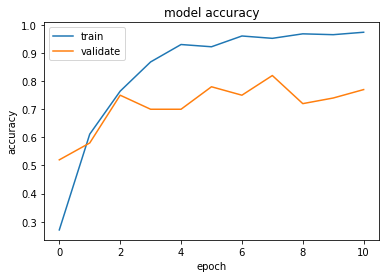

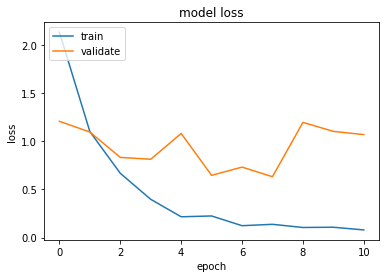

In [50]:
plot_history([history1, history2])

In [62]:
# Start Fine-tuning (train pre-trained model using new input data and some layers set to non-trainable.)
history3 = model.fit(X_train, Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          )

Train on 3000 samples, validate on 100 samples
Epoch 1/10
3000/3000 [==============================] - 176s - loss: 0.0812 - acc: 0.9753 - val_loss: 0.8673 - val_acc: 0.8200
Epoch 2/10
3000/3000 [==============================] - 178s - loss: 0.0566 - acc: 0.9850 - val_loss: 0.9405 - val_acc: 0.7400
Epoch 3/10
3000/3000 [==============================] - 177s - loss: 0.0225 - acc: 0.9937 - val_loss: 0.8218 - val_acc: 0.8100
Epoch 4/10
3000/3000 [==============================] - 177s - loss: 0.0181 - acc: 0.9957 - val_loss: 0.9937 - val_acc: 0.8000
Epoch 5/10
3000/3000 [==============================] - 177s - loss: 0.0263 - acc: 0.9913 - val_loss: 0.8338 - val_acc: 0.7900
Epoch 6/10
3000/3000 [==============================] - 177s - loss: 0.0148 - acc: 0.9967 - val_loss: 0.9732 - val_acc: 0.7900
Epoch 7/10
3000/3000 [==============================] - 177s - loss: 0.0016 - acc: 0.9997 - val_loss: 0.7611 - val_acc: 0.8500
Epoch 8/10
3000/3000 [==============================] - 177s - l

('len(histories):', 3)
(['acc', 'loss', 'val_acc', 'val_loss'], 21)
('acc', ':', 1.0)
('loss', ':', 0.00020551136513374029)
('val_acc', ':', 0.84999999999999998)
('val_loss', ':', 0.78627155303955076)


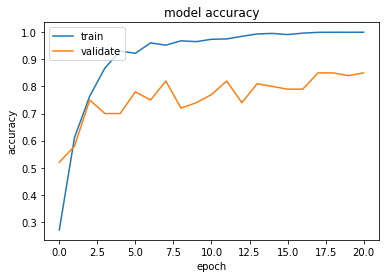

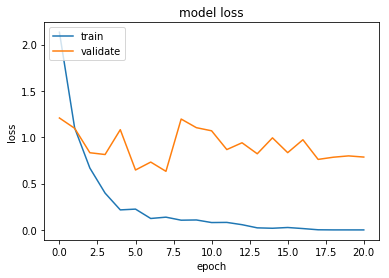

In [63]:
plot_history([history1, history2, history3])

In [54]:
# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

100/100 [==============================] - 2s     


In [55]:
# Cross-entropy loss score
score = log_loss(Y_valid, predictions_valid)


In [56]:
score

1.0739758813100466

In [57]:
model.evaluate(x=X_valid, y=Y_valid, batch_size=batch_size, verbose=1, sample_weight=None)

100/100 [==============================] - 2s     


[1.0697356128692628, 0.77000000000000002]

In [58]:
model.metrics_names

['loss', 'acc']